Homework 2 — (15 points)
======
### What to hand in
You are to submit the following things for this homework:
1. A Jupyter notebook containing all code and output (figures and audio). I should be able to evaluate the file to reproduce all output. 
1. Any other data that we tell you to save to a file (e.g. audio files).

### How to hand it in
To submit your lab:
1. Compress all of the files specified into a .zip file. 
1. Name the file in the following manner, firstname_lastname_hw1.zip. For example, Bryan_Pardo_hw1.zip. 
1. Submit this .zip file via Canvas

In [1]:
str ='Q: Whats the difference between a large pizza and a singer songwriter? A large pizza can feed a family of four!'
print(str[::-1])

!ruof fo ylimaf a deef nac azzip egral A ?retirwgnos regnis a dna azzip egral a neewteb ecnereffid eht stahW :Q


## Run this code block 1st, to import some needed packages

In [2]:
# This line is a convenience to import most packages you'll need. You may need to import others (eg random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

# Feel free to add some other imports here, if that is helpful



/home/harntson/miniconda2/envs/eecs352/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


## Implementing a spectrogram 

#### 1. (2 points) Make a short term Fourier transform (STFT) function.  

In [3]:
from scipy.fftpack import fft
from scipy.signal import hann

def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    #---------------------
    # your code goes below
    #---------------------
    
    # Calculate the number of windows
    n = len(signal)
    n_win = ( (float(n)-window_size) / (hop_size) ) + 1
    
    # Append zeros if necessary
    if math.ceil(n_win) > n_win:
        n_pad = int( ((math.ceil(n_win) - 1) * (hop_size)) + window_size)
        signal = np.lib.pad(signal, (0, n_pad-n,), 'constant')
   
    n_win = int(math.ceil(n_win))
    
    # Array of windows
    windows = np.empty((window_size, n_win), dtype=complex)
    for i in range(n_win):
        windows[:,i] = signal[i*hop_size : i*hop_size + window_size]
    
    # Apply windowing function if hann window
    if window_type=='hann':
        hann_win = sp.signal.hann(window_size)
        for i in range(n_win):
            windows[:,i] = windows[:,i]*hann_win
            
    # Run FFT on each window
    for i in range(n_win):
        windows[:,i] = sp.fftpack.fft(windows[:,i])
    
    return windows
    
    

#### 2. (2 points) 
1. **Make a signal $S$ of length 300 that has 1 for every one of its 300 samples.** 
1. **Make a signal $W_1$ by windowing signal $S$ with a Hann window of length 200, starting at index 0.**  
1. **Make signal $W_2$ by windowing signal $S$ with a Hann window of length 200, starting at index 100.** 
1. **Now....make a reconstruction of $S$ from $W_1$ and $W_2$ by overlapping the two windowed signals 50% (the same way you took them from $S$ and adding them together....where $W_1[100]$ would aling with $W_2[0]$. This is called "overlap and add." **

**How much does the reconstructed signal look like the original? What happens if these windows are not overlapped 50%, but by some other amount?**   

The reconstructed signal looks like the original signal in the middle where the windows overlapped. However, it still fades in and fades out at the beginning and the end, as those edges has nothing to overlap with.

When I changed the window overlap, things got worse. If the overlap was less then 50%, there was a dip in the middle of the reconstructed signal and the signal was longer. If the overlap was greater than 60%, the center amplitude was too high and the signal was too short.

Clearly, a 50% overlap's interferance will replicate the original signal as closely as possible

Original signal S


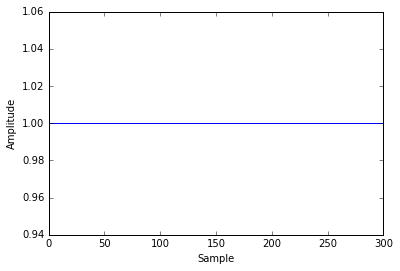

Reconstructed Signal with 50% Overlap


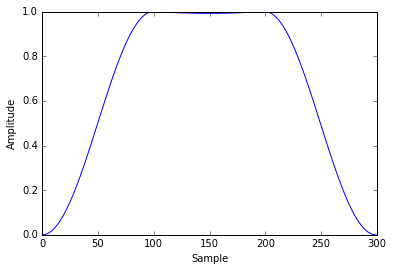

Reconstructed Signal with 40% Overlap


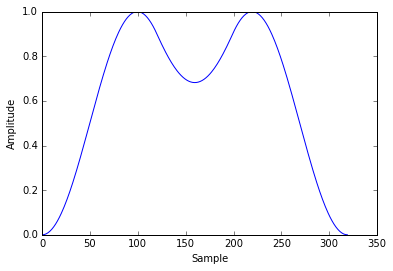

Reconstructed Signal with 60% Overlap


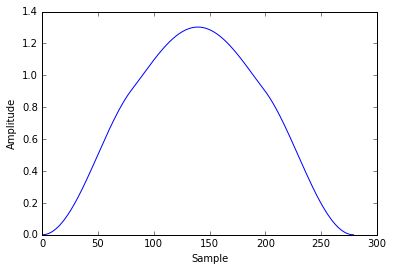

In [202]:
#---------------------
# your code goes below
#---------------------

# Helper functions
def overlap_add(percent, W1, W2):
    overlap = 1-percent
    W1 = np.lib.pad(W1, (0,int(200*overlap)), 'constant')
    W2 = np.lib.pad(W2, (int(200*overlap),0), 'constant')
    out = W1 + W2
    return out

def plt_sig(signal):
    plt.plot(signal)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

# Signal S of length 300
S = np.empty(300)
S.fill(1)

# Signal W1
hann_win = sp.signal.hann(200)
W1 = S[:200]*hann_win 

# Signal W2
W2 = S[100:]*hann_win

# Overlap and add
# 50% overlap
out50 = overlap_add(.5, W1, W2)

# 40% overlap
out40 = overlap_add(.4, W1, W2)

# 60% overlap
out60 = overlap_add(.6, W1, W2)

# Plot original signal and reconstructions
print "Original signal S"
plt_sig(S)

print "Reconstructed Signal with 50% Overlap"
plt_sig(out50)

print "Reconstructed Signal with 40% Overlap"
plt_sig(out40)

print "Reconstructed Signal with 60% Overlap"
plt_sig(out60)


#### 3. (2 points) Make an inverse STFT function to rebuild the original audio signal, using overlap & add resynthesis. You don't need to use a window function here.

In [6]:
from scipy.fftpack import ifft

def istft(X, hop_size):
    """
    Takes a 2-D numpy array representing an STFT of some signal, where stft[i] 
    is the FFT of the ith window as input and stft[i,k] is the kth frequency of analysis.
    Performs an inverse FFT on each window and then does overlap & add resynthesis to rebuild 
    the original signal the STFT was built from.
    
    Input Parameters
    ----------------
    X: a 2-D numpy array of complex numbers representing an STFT, where the ith 
    column is the FFT of the ith window, and the jth row is the jth frequency of analysis.
        
    hop_size: an integer specifying the number of samples between the start of adjacent windows.
        
    Returns
    -------
    a 1-d numpy array of (possibly complex) values representing the original signal used to make X
    """
    #---------------------
    # your code goes below
    #---------------------
    
    n_win = X.shape[1]
    
    # Perform an inverse FFT on each window
    for i in range(n_win):
        X[:,i] = sp.fftpack.ifft(X[:,i])
    
    # Calculate length of output signal
    n_elem = (n_win - 1)*hop_size + X.shape[0]
    out = np.empty(n_elem)
    
    # Overlap and add
    for i in range(n_win):
        temp = np.lib.pad(X[:,i], (i*hop_size, (n_win-1-i)*hop_size), 'constant')
        out = out + temp
    
    return out       
    

#### 4. (2 points) Display a magnitude spectrogram of an audio signal. Amplitude must be in dB. Correct frequencies must be displayed. Display only frequencies up to the Nyquist rate.  Time must be displayed in seconds. NOTE: you cannot use any functions in librosa to do this.

In [173]:
def spectrogram(signal, window_size, hop_size, sample_rate, window_type = 'hann', display = 1 ):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This creates a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    It then creates a magnitude spectrogram of the signal and plots it on the screen.
    Here, the vertical dimension is frequency (in Hz), the horizontal dimension is time
    (in seconds), brightness corresponds to amplitude (in dB). Only frequencies up to
    the Nyquist rate are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    window_type: a string specifying one of two "hann" or "rectangular"
    display: an integer. If set to 1, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    sgram:  a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram
           sgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency of analysis in Hz, up to the nyquist frequency
           
    Calling Example
    ---------------
    sgram,times,freqs = spectrogram(signal, window_size, hop_size, sample_rate )

    """ 
    #---------------------
    # your code goes below
    #---------------------
    
    # Call function stft
    stft_sig = stft(signal, window_size, hop_size, window_type)
    
    # Frequency range
    n = stft_sig.shape[0]

    # Create sgram array
    sgram = np.empty((stft_sig.shape[0]/2 + 1, stft_sig.shape[1]))
    
    for i in range(stft_sig.shape[1]):
        temp = stft_sig[:,i]
        # Magnitude in dBFS
        sgram[:,i] = 20.*(np.log10(temp[:(n/2+1)]))
    
    # Calculate time and frequency vectors
    times = np.arange(0,stft_sig.shape[1])
    times = (times*float(hop_size))/float(sample_rate)
    
    freqs = np.arange(0,(1 + n/2), 1)
    freqs = (freqs*float(sample_rate))/float(window_size)
    
    # Plot spectrogram
    if display==1:
        plt.pcolormesh(times, freqs, sgram)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Spectrogram')
        plt.axis([0, max(times), 0, max(freqs)])
        plt.colorbar()
        plt.show()
    
    return sgram, times, freqs
    

/home/harntson/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:55: ComplexWarning: Casting complex values to real discards the imaginary part


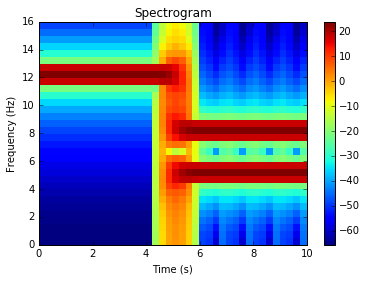

In [174]:
# Test Spectrogram
# Played around with example from textbook to test

# Plays a 12Hz sinewave for 5 seconds, then a 5Hz + 8Hz sinewave for 5 seconds
sr = 32
dt = np.arange(0,6.*sr)/sr
wave1 = np.sin(2*np.pi*12.*dt)
wave2 = np.sin(2*np.pi*5.*dt) + np.sin(2*np.pi*8.*dt)

wave = np.concatenate((wave1,wave2))

# Sample rate = 32
# Window size = 64
# Hop size = 8
sgram, times, freqs = spectrogram(wave, 64, 8, sr, display=1)


## Manipulating audio

#### 5. (1 point) Increase the speed of playback for the file piano.wav by 25%...but don't change the pitch. (don't use librosa)

In [207]:
# Original signal for comparison
piano, sr = librosa.load('piano.wav', sr=44100, duration=30)
Audio(piano, rate=sr)

In [159]:
#---------------------
# your code goes below
#---------------------

# Read in piano.wav
piano, sr = librosa.load('piano.wav', sr=44100, duration=30)
print "Original: %f seconds"%(len(piano)*(1./sr))

# Take STFT
# Window size = 4096
# Hop size = 2048 (N/2)
stft_sig = stft(piano, 4096, 2048)

# When reconstruction the signal, reduce the hop size by 25%
istft_sig = istft(stft_sig, 1536)

print "New signal: %f seconds"%(len(istft_sig)*(1./sr))

Audio(istft_sig, rate=sr)


Original: 11.000000 seconds
New signal: 8.277914 seconds


#### 6. (1 point) Now increase the pitch of file piano.wav by  two musical whole steps without changing the duration of the audio. (again.... don't use librosa)

In [220]:
#---------------------
# your code goes below
#---------------------

# Read in piano.wav
piano, sr = librosa.load('piano.wav', sr=44100, duration=30)

# Calculate playback rate to shift pitch up two whole steps
new_sr = int((2.**(4./12))*sr)

# Lengthen signal so that the final, pitch-shifted signal will be the correct length
stft_sig = stft(piano, 4096, int(2048*(float(sr)/new_sr)))
istft_sig = istft(stft_sig, 2048)

# Play back at new sampling rate
Audio(istft_sig, rate=new_sr)


55562


## Log Frequency 

#### 7. ( 2 points) Write a function that emulates triangular filters in the frequency domain. This function will be used to map from the linearly spaced frequencies of the STFT to another specified set of frequencies, with arbitrary spacing.



In [93]:
def make_triangular_filters(cfreqs, freqs ):
    """
    Computes a set of "filters" to apply to an STFT to change its frequency scaling.
    This takes an array of center frequencies (cfreqs) and a set of frequencies of 
    analysis (freqs) as input, both coded in Hz.  It will return a 2-D numpy array 
    filters[c][f], where c is the index number of a center frequency in cfreqs and 
    f is the index to a frequency in freqs and the value in filters[c][f] is a number 
    between 0 and 1 that represents how sensitive this filter is to that frequency.  
    Filters are triangular, with a linear decrease in sensitivity from the center 
    frequency (sensitivity = 1) down to a sensitivity of 0 by the center frequency 
    of each adjacent freqency.
    
    Input Parameters
    ----------------
    cfreqs: a 1-D python array of center frequencies measured in Hz
    freqs:   a 1-D python array of frequencies for whom we need to calculate the sensitivity
             of each filter
    
    Returns
    -------
    filters: a 2-D numpy array, where c is the index number of a center frequency in 
            cfreqs and f is the index to a frequency in freqs and the value in filters[c][f] 
            is a number between 0 and 1 that represents how sensitive this filter is to 
            that frequency.
    """
    #---------------------
    # your code goes below
    #---------------------
    
    filters = np.empty((len(cfreqs), len(freqs)), dtype='float')
    
    # Endpoints of all triangles
    ends = np.lib.pad(cfreqs, (1,0), 'constant')
    ends = np.append(ends, max(freqs))
    
    # For each triangle
    for c in range(len(cfreqs)):
        # Generate sensitivities
        for f in range(len(freqs)):
            if (freqs[f]>ends[c])and(freqs[f]<ends[c+2]):
                # Get ratio
                if freqs[f]<cfreqs[c]:
                    filters[c][f] = 1-((cfreqs[c]-freqs[f]) * (1./(cfreqs[c]-ends[c])))
                else:
                    filters[c][f] = abs((ends[c+2]-freqs[f]) * (1./(cfreqs[c]-ends[c+2])))
            else:
                filters[c][f] = 0.
    
    return filters
    

#### 8. (1 point) You have been given a set of input frequencies spaced 1 Hz apart and ranging from the bottom piano note to the top note...and a second set of a center frequencies that are spaced with 1 per key on the piano. Use your code from problem 7 to create a filterbank, mapping the energy from the first set of frequencies to the second set of frequencies. Then display the filterbank as a 2-D image where the vertical dimension is freq in Hz, the horizontal dimension is the index of a filter (i.e. the piano key number) and the color gives the strength of the filter response. Label your dimensions. Also, give a list of the piano key frequencies below the plot. 

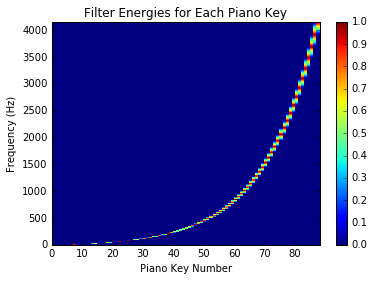


Piano Key Frequencies:

[   27.5           29.13523509    30.86770633    32.70319566    34.64782887
    36.70809599    38.89087297    41.20344461    43.65352893    46.24930284
    48.9994295     51.9130872     55.            58.27047019    61.73541266
    65.40639133    69.29565774    73.41619198    77.78174593    82.40688923
    87.30705786    92.49860568    97.998859     103.82617439   110.
   116.54094038   123.47082531   130.81278265   138.59131549   146.83238396
   155.56349186   164.81377846   174.61411572   184.99721136   195.99771799
   207.65234879   220.           233.08188076   246.94165063   261.6255653
   277.18263098   293.66476792   311.12698372   329.62755691   349.22823143
   369.99442271   391.99543598   415.30469758   440.           466.16376152
   493.88330126   523.2511306    554.36526195   587.32953583   622.25396744
   659.25511383   698.45646287   739.98884542   783.99087196   830.60939516
   880.           932.32752304   987.76660251  1046.5022612   1108.73052

In [227]:
# A440 is 39 keys from the top of the piano and 44 keys from the bottom
top_piano_note =  440*2**(39.0/12)
bottom_piano_note = 440*2**(-48.0/12)

# our frequencies will be spaced 1 Hz appart in this domain
freqs = np.linspace(bottom_piano_note,top_piano_note,(top_piano_note-bottom_piano_note + 1))

# our center frequencies will be spaced with one per piano note
cfreqs = bottom_piano_note * np.logspace(0, 87.0/12, 88, base=2)

#---------------------
# your code goes below
#---------------------

# Filterbank of keys
filters = make_triangular_filters(cfreqs, freqs)
filters = filters.transpose()

# Plot
plt.pcolormesh(filters)
plt.title('Filter Energies for Each Piano Key')
plt.xlabel('Piano Key Number')
plt.ylabel('Frequency (Hz)')
plt.axis([0, filters.shape[1], 0, filters.shape[0]])
plt.colorbar()
plt.show()

# Print piano key frequencies
print ""
print "Piano Key Frequencies:"
print ""
print cfreqs


#### 9. (2 point)  Use the mapping from frequency $f$ to mel $m$ defined in (1) to make a mel-frequency filter bank with 40 filters, evenly spaced in mels, that covers the same range as the piano-note spaced filterbank.  Display a plot of it. Give a list of the mel frequencies (in Hz). Do you think this number of filters and spacing appropriately captures the salient aspects of music? Why or why not?

$m = 2595log_{10}(1+\frac{f}{700})$

(1) Douglas O'Shaughnessy (1987). Speech communication: human and machine. Addison-Wesley. p. 150. ISBN 978-0-201-16520-3.

your answer (including math) goes here





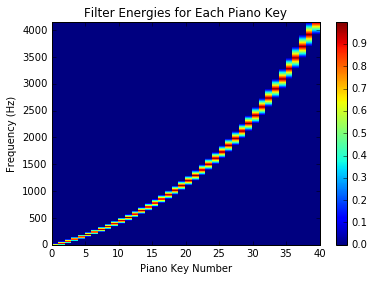

In [193]:
#---------------------
# your code goes below
#---------------------

# A440 is 39 keys from the top of the piano and 44 keys from the bottom
top_piano_note =  440*2**(39.0/12)
bottom_piano_note = 440*2**(-48.0/12)

# our frequencies will be spaced 1 Hz appart in this domain
freqs = np.linspace(bottom_piano_note,top_piano_note,(top_piano_note-bottom_piano_note + 1))

# Range in mels
mel_top = 2595*np.log10(1 + top_piano_note/700.)
mel_bottom = 2585*np.log10(1 + bottom_piano_note/700.)

# 40 center frequencies are evenly spaced in mels
mels = np.linspace(mel_bottom, mel_top, 40)

# Convert to frequency in Hz
cfreqs = (10**(mels/2595.) - 1)*700

# Create mel filterbank
filters = make_triangular_filters(cfreqs, freqs)
filters = filters.transpose()

# Plot
plt.pcolormesh(filters)
plt.title('Filter Energies Range')
plt.xlabel('Piano Key Number')
plt.ylabel('Frequency (Hz)')
plt.axis([0, filters.shape[1], 0, filters.shape[0]])
plt.colorbar()
plt.show()